Nama : Mohammad Iqbal Jaffar

Email : iqbaljaffar1108@gmail.com

# REVIEW SENTIMENT PADA APLIKASI M-PAJAK/CORETAX

# **Data Preparation**

In [1]:
# Instalasi pustaka yang diperlukan
!pip install google-play-scraper -q
!pip install Sastrawi -q
!pip install tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.1 MB/s eta 0:00:00


In [2]:
# Mengimpor pustaka yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
from io import StringIO
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google_play_scraper import reviews_all, Sort

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer # CountVectorizer juga bisa jadi alternatif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import csv
import requests

In [3]:
# Mengatur opsi Pandas
pd.options.mode.chained_assignment = None

In [4]:
# Mengatur seed untuk reproduktibilitas
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# Mengunduh dataset yang diperlukan untuk NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

## **Scraping Dataset Mandiri**

In [6]:
# ID Aplikasi Target (pajak di Google Play Store)
APP_ID = 'id.go.pajak.djp'
CSV_FILENAME = "pajak_reviews_min10k.csv"
MIN_SAMPLES = 10000

try:
    # Coba muat data yang sudah ada
    data = pd.read_csv(CSV_FILENAME)
    if len(data) < MIN_SAMPLES:
        print(f"Data yang ada hanya {len(data)} sampel. Menjalankan scraping untuk mendapatkan lebih banyak...")
        raise FileNotFoundError # Paksa scraping jika data kurang
    print(f"Berhasil memuat {len(data)} data dari {CSV_FILENAME}.")
except FileNotFoundError:
    print(f"File {CSV_FILENAME} tidak ditemukan atau data kurang. Melakukan scraping data ulasan...")
    # Mengambil minimal 10.000 ulasan, atau lebih untuk cadangan setelah pembersihan
    scraped_reviews = reviews_all(
        APP_ID,
        lang='id',
        country='id',
        sort=Sort.NEWEST, # Atau Sort.MOST_RELEVANT
        count=MIN_SAMPLES + 2000, # Ambil lebih untuk antisipasi data kosong/duplikat
        filter_score_with=None
    )

    df_scraped = pd.DataFrame(np.array(scraped_reviews), columns=['reviews'])
    df_scraped = df_scraped.join(pd.DataFrame(df_scraped.pop('reviews').tolist()))

    print(f"Scraping selesai, {len(df_scraped)} ulasan berhasil diambil.")
    df_scraped.to_csv(CSV_FILENAME, index=False)
    print(f"Data ulasan disimpan ke {CSV_FILENAME}")
    data = df_scraped.copy()

File pajak_reviews_min10k.csv tidak ditemukan atau data kurang. Melakukan scraping data ulasan...
Scraping selesai, 5222 ulasan berhasil diambil.
Data ulasan disimpan ke pajak_reviews_min10k.csv


In [7]:
# Pemilihan Kolom dan Pembersihan Awal
if 'content' in data.columns and 'score' in data.columns:
    data = data[['content', 'score']]
    data.rename(columns={'score': 'rating', 'content': 'comment'}, inplace=True)
else:
    # Jika nama kolom berbeda karena versi scraper atau sumber lain
    # Sesuaikan dengan nama kolom yang benar dari hasil scraping Anda
    # Misalnya, jika kolomnya 'text' dan 'star'
    # data = data[['text', 'star']]
    # data.rename(columns={'star': 'rating', 'text': 'comment'}, inplace=True)
    print("PERINGATAN: Kolom 'content' atau 'score' tidak ditemukan. Periksa nama kolom hasil scraping Anda.")
    # Hentikan eksekusi atau tangani error jika kolom penting tidak ada

data.dropna(subset=['comment', 'rating'], inplace=True)
data = data[data['comment'].apply(lambda x: isinstance(x, str) and x.strip() != "")] # Pastikan komentar adalah string & tidak kosong
data['rating'] = pd.to_numeric(data['rating'], errors='coerce') # Pastikan rating numerik
data.dropna(subset=['rating'], inplace=True) # Hapus jika rating tidak valid
data.drop_duplicates(subset=['comment'], keep='first', inplace=True)

print(f"Jumlah data setelah loading dan pembersihan awal: {len(data)}")
if len(data) < MIN_SAMPLES:
    print(f"PERINGATAN: Jumlah data unik ({len(data)}) kurang dari target minimal {MIN_SAMPLES} setelah pembersihan. Anda mungkin perlu scraping lebih banyak.")
data.head()

Jumlah data setelah loading dan pembersihan awal: 4710
PERINGATAN: Jumlah data unik (4710) kurang dari target minimal 10000 setelah pembersihan. Anda mungkin perlu scraping lebih banyak.


,comment,rating
0,saya kurang mengerti dan memahami bagaimana pe...,2
1,ribet,1
2,Gak guna !!!,1
3,"sa kesal sekali, buat NPWP jadi susah semenjak...",1
4,"jangan nerima duit setoran pajak aja, perbaiki...",1


## **Tahapan Ekstraksi Fitur**

### **Preprocessing Text**

In [8]:
# Kamus untuk memperbaiki kata slang (bisa terus ditambahkan)
slangwords = {
    "bug": "kesalahan", "dll": "dan lain lain", "ckp": "cukup", "tw": "tahu", "tau": "tahu",
    "aku": "saya", "ga": "tidak", "gk":"tidak", "nggak":"tidak", "gak":"tidak", "kalo": "kalau", "ngelag": "lag", "nge lag": "lag",
    "CUAPEKKK": "capek", "tak": "tidak", "memory": "memori", "trus": "terus", "trs":"terus",
    "patah patah": "lag", "ku": "saya", "error": "kesalahan", "ane":"saya",
    "full": "penuh", "&": "dan", "Adli": "adil", "tdk": "tidak", "Dpt": "dapat",
    "tollol": "bodoh", "smua": "semua", "Thank's": "terima kasih", "thanks":"terima kasih",
    "game nya": "gim ini", "game": "gim", "bg": "abang", "sdh": "sudah", "bgt": "banget",
    "udah": "sudah", "jg": "juga", "lg": "lagi", "hp": "ponsel", "aj": "saja", "ae":"saja",
    "kpn": "kapan", "kyk": "seperti", "org": "orang", "grafik nya": "grafiknya", "grafik":"grafis",
    "tp": "tapi", "update": "pembaruan", "mn": "mana", "gajelas": "tidak jelas", "knp": "kenapa",
    "dr": "dari", "emg": "memang", "parahhh": "parah", "gacha": "gaca", "byk":"banyak",
    "mantap":"bagus", "keren":"bagus", "good":"bagus", "best":"terbaik", "nice":"bagus",
    "jelek":"buruk", "payah":"buruk", "parah":"buruk", "goblok":"bodoh", "tolol":"bodoh"
}

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [10]:
stop_words_id = list(stopwords.words('indonesian'))
stop_words_en = list(stopwords.words('english'))
custom_stopwords_list = {
    'sih', 'nya', 'nih', 'kok', 'deh', 'dong', 'mah', 'kek', 'sih', 'banget', 'amat', 'nan',
    'iya', 'yaa', 'gak', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woy', 'yg', 'dg', 'rt', 'dgn',
    'ny', 'd', 'klo', 'kalo', 'amp', 'biar', 'bikin', 'bilang', 'krn', 'jd', 'jgn', 'sdh',
    'aja', 'n', 't', 'nyg', 'hehe', 'pen', 'u', 'wkwk', 'wkwkwk', 'haha', 'sksksk', 'anjay',
    'gue', 'gw', 'elu', 'lu', 'sy', 'aq', 'gimana', 'gitu', 'gini', 'gt', 'gn', 'ayo', 'yuk'
}
all_stopwords = set(stop_words_id + stop_words_en).union(custom_stopwords_list)


In [11]:
def cleaning_text(text):
    text = str(text).lower() # Case folding
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Hapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', text) # Hapus hashtag
    text = re.sub(r'RT[\s]+', ' ', text) # Hapus RT
    text = re.sub(r"http\S+|www\S+|https\S+", ' ', text, flags=re.MULTILINE) # Hapus URL
    text = re.sub(r'\d+', ' ', text) # Hapus angka
    text = text.translate(str.maketrans("","",string.punctuation)) # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    # Hapus karakter non-alfabet (opsional, bisa menghapus emoji atau simbol penting)
    # text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [12]:
def fix_slang_and_tokenize(text):
    words = text.split()
    # Normalisasi slang
    fixed_words = [slangwords.get(word, word) for word in words]
    # Tokenisasi (sebenarnya sudah jadi list of words)
    return fixed_words

In [13]:
def filter_stopwords_and_shortwords(tokens):
    # Hapus stopwords dan kata yang terlalu pendek (kurang dari 2 atau 3 huruf)
    return [token for token in tokens if token not in all_stopwords and len(token) > 2]

In [14]:
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

In [15]:
def to_sentence(list_words):
    return ' '.join(list_words)

In [16]:
# Pipeline Preprocessing
print("Memulai preprocessing teks...")
data['text_cleaned'] = data['comment'].apply(cleaning_text)
data['text_tokenized'] = data['text_cleaned'].apply(fix_slang_and_tokenize) # Ini sudah menghasilkan token
data['text_filtered'] = data['text_tokenized'].apply(filter_stopwords_and_shortwords)
data['text_stemmed'] = data['text_filtered'].apply(stem_tokens)
data['text_final'] = data['text_stemmed'].apply(to_sentence)

Memulai preprocessing teks...


In [17]:
# Hapus baris yang teks finalnya kosong setelah preprocessing
data = data[data['text_final'] != '']
data.reset_index(drop=True, inplace=True)
print(f"Jumlah data setelah preprocessing teks dan penghapusan teks kosong: {len(data)}")
data[['comment', 'text_final', 'rating']].head()

Jumlah data setelah preprocessing teks dan penghapusan teks kosong: 4643


,comment,text_final,rating
0,saya kurang mengerti dan memahami bagaimana pe...,erti paham guna aplikasi inisering telp mengat...,2
1,ribet,ribet,1
2,"sa kesal sekali, buat NPWP jadi susah semenjak...",kesal npwp susah semenjak cortax verif malam b...,1
3,"jangan nerima duit setoran pajak aja, perbaiki...",nerima duit setor pajak baik system webaplikas...,1
4,aneh kita yang bayar pajak kita yang laporan. ...,aneh bayar pajak lapor lapor sulit data,1


### **Pelabelan Data (3 Kelas)**

In [18]:
# Berdasarkan 'rating', kita akan membuat 3 kelas: positif, netral, negatif.
def sentiment_label_from_rating(rating):
    rating = int(rating) # Pastikan integer
    if rating in [1, 2]:
        return 'negatif'
    elif rating == 3:
        return 'netral'
    elif rating in [4, 5]:
        return 'positif'
    return 'tidak diketahui' # Seharusnya tidak terjadi jika data rating bersih

In [19]:
data['sentiment'] = data['rating'].apply(sentiment_label_from_rating)
data = data[data['sentiment'] != 'tidak diketahui'] # Hapus jika ada label tidak diketahui

In [20]:
print("\nDistribusi Sentimen:")
print(data['sentiment'].value_counts())


Distribusi Sentimen:
sentiment
negatif    3846
positif     646
netral      151
Name: count, dtype: int64


<ipython-input-21-cbf4191ab596>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, order=['positif', 'netral', 'negatif'], palette={'positif':'#2ECC71', 'netral':'#F1C40F', 'negatif':'#E74C3C'})


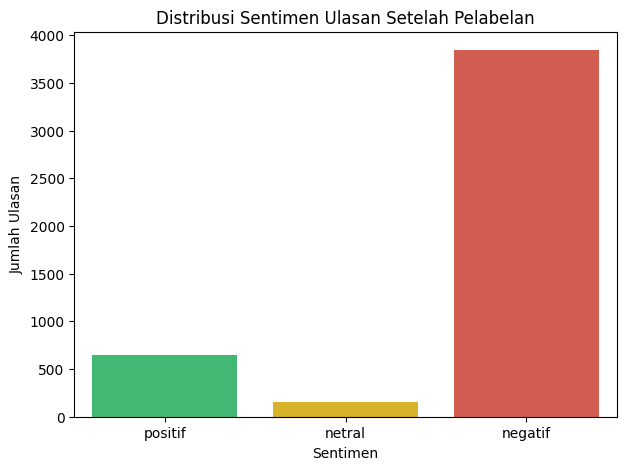

In [21]:
# Visualisasi Distribusi Sentimen
plt.figure(figsize=(7, 5))
sns.countplot(x='sentiment', data=data, order=['positif', 'netral', 'negatif'], palette={'positif':'#2ECC71', 'netral':'#F1C40F', 'negatif':'#E74C3C'})
plt.title('Distribusi Sentimen Ulasan Setelah Pelabelan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

In [22]:
# Cek apakah ada cukup data untuk setiap kelas
min_samples_per_class = 100 # Bisa disesuaikan
class_counts = data['sentiment'].value_counts()
if (class_counts < min_samples_per_class).any():
    print(f"\nPeringatan: Beberapa kelas memiliki kurang dari {min_samples_per_class} sampel. Ini bisa mempengaruhi pelatihan model.")
    print(class_counts)
    # Pertimbangkan oversampling/undersampling jika sangat tidak seimbang dan model underperform.

In [23]:
# DataFrame final untuk model
data_model = data[['text_final', 'sentiment']].copy()
data_model.reset_index(drop=True, inplace=True)

In [24]:
print(f"\nJumlah data siap untuk model: {len(data_model)}")
print(data_model.head())


Jumlah data siap untuk model: 4643
                                          text_final sentiment
0  erti paham guna aplikasi inisering telp mengat...   negatif
1                                              ribet   negatif
2  kesal npwp susah semenjak cortax verif malam b...   negatif
3  nerima duit setor pajak baik system webaplikas...   negatif
4            aneh bayar pajak lapor lapor sulit data   negatif


In [25]:
# Hapus variabel yang tidak terpakai untuk membebaskan memori
del data

### **Eksplorasi Label dengan Word Cloud**

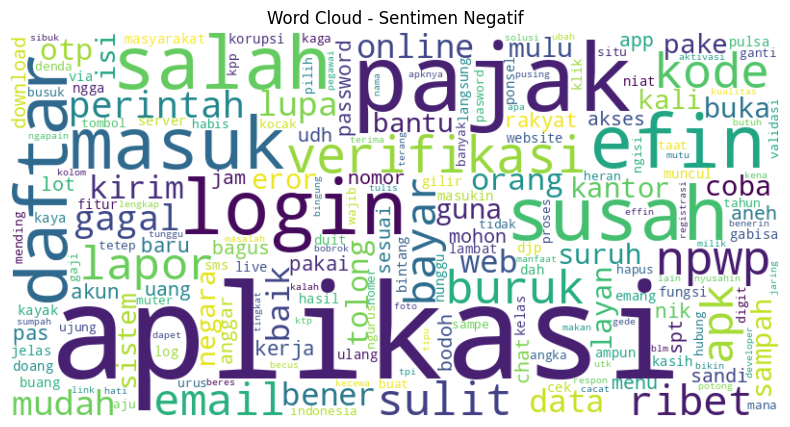

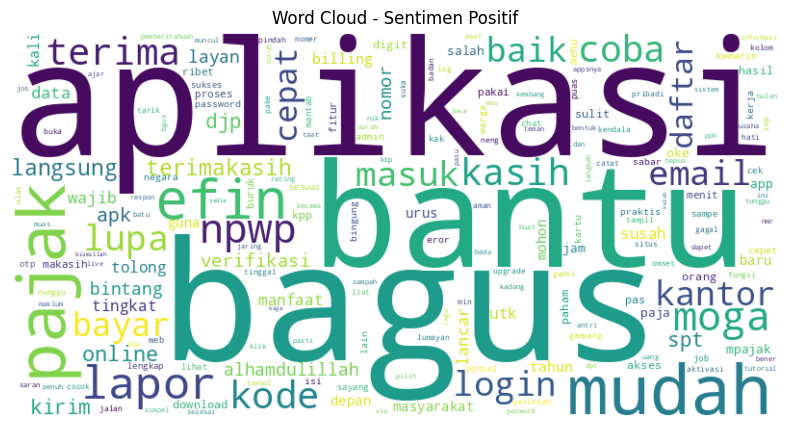

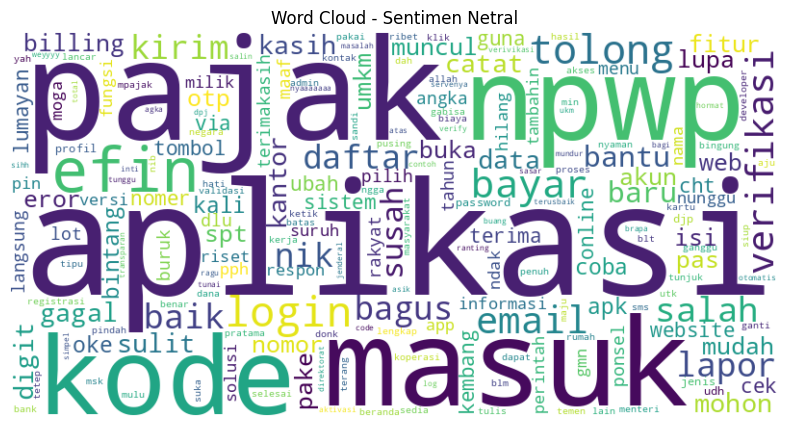

In [26]:
# Pastikan kolom 'text_final' dan 'sentiment' ada
if 'text_final' in data_model.columns and 'sentiment' in data_model.columns:
    sentiment_categories = data_model['sentiment'].unique()
    for sentiment_cat in sentiment_categories:
        subset_texts = " ".join(data_model[data_model['sentiment'] == sentiment_cat]['text_final'].tolist())
        if subset_texts.strip(): # Hanya generate wordcloud jika ada teks
            try:
                wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False, random_state=seed).generate(subset_texts)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'Word Cloud - Sentimen {sentiment_cat.capitalize()}')
                plt.axis('off')
                plt.show()
            except ValueError as e:
                print(f"Tidak bisa membuat word cloud untuk sentimen {sentiment_cat}: {e}")
        else:
            print(f"Tidak ada teks untuk menghasilkan word cloud sentimen {sentiment_cat}.")
else:
    print("Kolom 'text_final' atau 'sentiment' tidak ditemukan dalam DataFrame.")

# **Modelling**

In [27]:
# Variabel global untuk menyimpan hasil dan model
results_summary = []
best_models_and_vectorizers = {} # Untuk menyimpan model terbaik dan vectorizer/tokenizer terkait

In [28]:
# Fungsi untuk melatih dan evaluasi model ML Klasik
def train_evaluate_classical_model(X_train, y_train, X_test, y_test, model_pipeline, model_name, skema_name, feature_method, data_split_ratio):
    print(f"\n--- Melatih Model: {model_name} untuk {skema_name} ---")
    model_pipeline.fit(X_train, y_train) # Pipeline sudah termasuk vectorizer (jika ada) dan model

    y_pred_train = model_pipeline.predict(X_train)
    y_pred_test = model_pipeline.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    print(f"Akurasi Training {model_name}: {acc_train:.4f}")
    print(f"Akurasi Testing {model_name}: {acc_test:.4f}")
    print("Laporan Klasifikasi (Test Set):")
    # Pastikan semua label ada di y_test dan y_pred_test untuk laporan yang benar
    unique_labels = sorted(list(set(y_test) | set(y_pred_test)))
    print(classification_report(y_test, y_pred_test, labels=unique_labels, target_names=unique_labels, zero_division=0))

    results_summary.append({
        'skema': skema_name,
        'model': model_name,
        'fitur': feature_method,
        'pembagian_data': data_split_ratio,
        'akurasi_train': acc_train,
        'akurasi_test': acc_test
    })

    if acc_test >= 0.85: # Kriteria minimal
        # Jika menggunakan pipeline sklearn, model dan vectorizer ada di dalamnya
        best_models_and_vectorizers[f"{skema_name}_{model_name}"] = {
            'pipeline': model_pipeline, # Simpan seluruh pipeline
            'accuracy_test': acc_test,
            'feature_type': feature_method,
            'model_type': 'classical'
        }
    return acc_train, acc_test, model_pipeline

In [29]:
# Data yang akan digunakan
X_texts = data_model['text_final']
y_labels = data_model['sentiment']

In [30]:
# Label Encoding untuk y (jika model tertentu membutuhkannya atau untuk konsistensi)
# Beberapa model sklearn bisa menangani label string, tapi ada baiknya di-encode
label_encoder_global = LabelEncoder()
y_encoded = label_encoder_global.fit_transform(y_labels)
sentiment_mapping = dict(zip(label_encoder_global.classes_, label_encoder_global.transform(label_encoder_global.classes_)))
print("Pemetaan Sentimen ke Angka:", sentiment_mapping)

Pemetaan Sentimen ke Angka: {'negatif': np.int64(0), 'netral': np.int64(1), 'positif': np.int64(2)}


In [31]:
# --- SKEMA 1: TF-IDF + Logistic Regression (Pembagian Data 80/20) ---
print("\n\n" + "="*10 + " SKEMA 1: TF-IDF + Logistic Regression (80/20) " + "="*10)
SKEMA_NAME_1 = "Skema 1"
FEATURE_METHOD_1 = "TF-IDF"
DATA_SPLIT_1 = "80/20"



========== SKEMA 1: TF-IDF + Logistic Regression (80/20) ==========


In [32]:
X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(
    X_texts, y_labels, test_size=0.2, random_state=seed, stratify=y_labels
)

In [33]:
# Definisikan TF-IDF Vectorizer
tfidf_vectorizer_s1 = TfidfVectorizer(max_features=7000, min_df=3, max_df=0.7, ngram_range=(1,2))

In [34]:
# Pipeline untuk Logistic Regression
# (GridSearchCV bisa dilakukan di dalam pipeline atau di atasnya)
logreg_model = LogisticRegression(random_state=seed, solver='liblinear', class_weight='balanced', max_iter=1000)
pipeline_logreg = GridSearchCV(
    estimator=logreg_model,
    param_grid={'C': [0.01, 0.1, 1, 10]}, # solver dan penalty disesuaikan dengan liblinear
    cv=5, # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1
)

In [35]:
# Gabungkan vectorizer dan model dalam satu pipeline (untuk kemudahan, meski GridSearchCV dilakukan pada modelnya)
# Cara yang lebih tepat adalah GridSearch pada Pipeline-nya
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([
    ('tfidf', tfidf_vectorizer_s1),
    ('gridsearch_lr', pipeline_logreg) # gridsearch_lr di sini adalah estimatornya, bukan pipeline
])

In [36]:
# Untuk sementara, kita fit TF-IDF dulu, lalu GridSearchCV pada model
X_train_tfidf_s1 = tfidf_vectorizer_s1.fit_transform(X_train_s1)
X_test_tfidf_s1 = tfidf_vectorizer_s1.transform(X_test_s1)

In [37]:
print(f"Bentuk matriks TF-IDF Training (Skema 1): {X_train_tfidf_s1.shape}")
pipeline_logreg.fit(X_train_tfidf_s1, y_train_s1)
print(f"Parameter terbaik Logistic Regression (Skema 1): {pipeline_logreg.best_params_}")
lr_best_s1 = pipeline_logreg.best_estimator_

Bentuk matriks TF-IDF Training (Skema 1): (3714, 2104)
Parameter terbaik Logistic Regression (Skema 1): {'C': 1}


In [38]:
# Untuk menyimpan ke best_models_and_vectorizers, kita perlu simpan vectorizer dan model terbaiknya
# Kita buat pipeline manual setelah mendapatkan model terbaik
final_pipeline_lr_s1 = Pipeline([
    ('tfidf', tfidf_vectorizer_s1), # Vectorizer yang sudah di-fit ke data training S1
    ('classifier', lr_best_s1)
])

In [39]:
# Evaluasi menggunakan data mentah (pipeline akan transform X_test_s1)
train_evaluate_classical_model(X_train_s1, y_train_s1, X_test_s1, y_test_s1, final_pipeline_lr_s1, "Logistic Regression (Best)", SKEMA_NAME_1, FEATURE_METHOD_1, DATA_SPLIT_1)


--- Melatih Model: Logistic Regression (Best) untuk Skema 1 ---
Akurasi Training Logistic Regression (Best): 0.9163
Akurasi Testing Logistic Regression (Best): 0.8654
Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

     negatif       0.90      0.96      0.93       770
      netral       0.10      0.07      0.08        30
     positif       0.73      0.47      0.58       129

    accuracy                           0.87       929
   macro avg       0.58      0.50      0.53       929
weighted avg       0.85      0.87      0.85       929



(0.9162627894453419,
 0.8654467168998924,
 Pipeline(steps=[('tfidf',
                  TfidfVectorizer(max_df=0.7, max_features=7000, min_df=3,
                                  ngram_range=(1, 2))),
                 ('classifier',
                  LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                     random_state=42, solver='liblinear'))]))

In [40]:
# --- SKEMA 2: TF-IDF + SVM (Pembagian Data 75/25 atau Algoritma Berbeda) ---
print("\n\n" + "="*10 + " SKEMA 2: TF-IDF + SVM (75/25) " + "="*10)
SKEMA_NAME_2 = "Skema 2"
FEATURE_METHOD_2 = "TF-IDF" # Masih menggunakan TF-IDF
DATA_SPLIT_2 = "75/25"



========== SKEMA 2: TF-IDF + SVM (75/25) ==========


In [41]:
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    X_texts, y_labels, test_size=0.25, random_state=seed, stratify=y_labels # Pembagian data berbeda
)

In [42]:
# Gunakan TF-IDF Vectorizer baru atau yang sudah ada (jika ingin konsisten fiturnya)
# Kita buat baru untuk skema ini agar independen, tapi bisa juga pakai yang dari Skema 1
tfidf_vectorizer_s2 = TfidfVectorizer(max_features=7000, min_df=3, max_df=0.7, ngram_range=(1,2))
X_train_tfidf_s2 = tfidf_vectorizer_s2.fit_transform(X_train_s2)
X_test_tfidf_s2 = tfidf_vectorizer_s2.transform(X_test_s2)
print(f"Bentuk matriks TF-IDF Training (Skema 2): {X_train_tfidf_s2.shape}")

Bentuk matriks TF-IDF Training (Skema 2): (3482, 1977)


In [43]:
# Model SVM dengan GridSearchCV
# SVM bisa lambat, jadi parameter grid mungkin perlu disederhanakan atau gunakan subset data untuk tuning
svm_model = SVC(random_state=seed, class_weight='balanced', probability=True) # probability=True untuk predict_proba
pipeline_svm = GridSearchCV(
    estimator=svm_model,
    param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']},
    cv=3, # Kurangi CV fold untuk kecepatan jika perlu
    scoring='accuracy',
    n_jobs=-1
)

In [44]:
pipeline_svm.fit(X_train_tfidf_s2, y_train_s2)
print(f"Parameter terbaik SVM (Skema 2): {pipeline_svm.best_params_}")
svm_best_s2 = pipeline_svm.best_estimator_

Parameter terbaik SVM (Skema 2): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [45]:
final_pipeline_svm_s2 = Pipeline([
    ('tfidf', tfidf_vectorizer_s2),
    ('classifier', svm_best_s2)
])
train_evaluate_classical_model(X_train_s2, y_train_s2, X_test_s2, y_test_s2, final_pipeline_svm_s2, "SVM (Best)", SKEMA_NAME_2, FEATURE_METHOD_2, DATA_SPLIT_2)


--- Melatih Model: SVM (Best) untuk Skema 2 ---
Akurasi Training SVM (Best): 0.9549
Akurasi Testing SVM (Best): 0.8613
Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

     negatif       0.91      0.93      0.92       962
      netral       0.20      0.13      0.16        38
     positif       0.63      0.60      0.62       161

    accuracy                           0.86      1161
   macro avg       0.58      0.56      0.57      1161
weighted avg       0.85      0.86      0.86      1161



(0.9549109707064906,
 0.8613264427217916,
 Pipeline(steps=[('tfidf',
                  TfidfVectorizer(max_df=0.7, max_features=7000, min_df=3,
                                  ngram_range=(1, 2))),
                 ('classifier',
                  SVC(C=1, class_weight='balanced', probability=True,
                      random_state=42))]))

In [46]:
# Alternatif untuk Skema 2: Random Forest
print("\n\n" + "="*10 + " SKEMA 2 (Alternatif): TF-IDF + Random Forest (75/25) " + "="*10)
SKEMA_NAME_2_ALT = "Skema 2 (Alt RF)"
rf_model = RandomForestClassifier(random_state=seed, class_weight='balanced', n_jobs=-1)
pipeline_rf = GridSearchCV(
    estimator=rf_model,
    param_grid={'n_estimators': [100, 200], 'max_depth': [None, 20, 30], 'min_samples_split': [2, 5]},
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)



========== SKEMA 2 (Alternatif): TF-IDF + Random Forest (75/25) ==========


In [47]:
pipeline_rf.fit(X_train_tfidf_s2, y_train_s2) # Menggunakan X_train_tfidf_s2 yang sama
print(f"Parameter terbaik Random Forest (Skema 2 Alt): {pipeline_rf.best_params_}")
rf_best_s2_alt = pipeline_rf.best_estimator_

Parameter terbaik Random Forest (Skema 2 Alt): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [48]:
final_pipeline_rf_s2_alt = Pipeline([
    ('tfidf', tfidf_vectorizer_s2), # Gunakan vectorizer yang sama dengan SVM di Skema 2
    ('classifier', rf_best_s2_alt)
])
train_evaluate_classical_model(X_train_s2, y_train_s2, X_test_s2, y_test_s2, final_pipeline_rf_s2_alt, "Random Forest (Best)", SKEMA_NAME_2_ALT, FEATURE_METHOD_2, DATA_SPLIT_2)


--- Melatih Model: Random Forest (Best) untuk Skema 2 (Alt RF) ---
Akurasi Training Random Forest (Best): 0.9627
Akurasi Testing Random Forest (Best): 0.8484
Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

     negatif       0.91      0.92      0.91       962
      netral       0.07      0.03      0.04        38
     positif       0.57      0.62      0.60       161

    accuracy                           0.85      1161
   macro avg       0.52      0.52      0.52      1161
weighted avg       0.84      0.85      0.84      1161



(0.9626651349798966,
 0.8484065460809647,
 Pipeline(steps=[('tfidf',
                  TfidfVectorizer(max_df=0.7, max_features=7000, min_df=3,
                                  ngram_range=(1, 2))),
                 ('classifier',
                  RandomForestClassifier(class_weight='balanced',
                                         min_samples_split=5, n_jobs=-1,
                                         random_state=42))]))

In [49]:
# --- SKEMA 3: Deep Learning (Bidirectional LSTM) ---
print("\n\n" + "="*10 + " SKEMA 3: Deep Learning - BiLSTM (80/20) " + "="*10)
SKEMA_NAME_3 = "Skema 3 (Deep Learning)"
FEATURE_METHOD_3 = "Keras Embedding"
DATA_SPLIT_3 = "80/20 (dengan validation_split)"



========== SKEMA 3: Deep Learning - BiLSTM (80/20) ==========


In [50]:
# Persiapan Data untuk Deep Learning
MAX_NUM_WORDS = 15000  # Ukuran vocabulary (sesuaikan berdasarkan data Anda)
MAX_SEQUENCE_LENGTH = 120 # Panjang sekuens maksimum (sesuaikan)
EMBEDDING_DIM = 128 # Dimensi embedding vector

In [51]:
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<oov>")
keras_tokenizer.fit_on_texts(X_texts) # Fit pada semua data teks
word_index = keras_tokenizer.word_index
print(f"Ditemukan {len(word_index)} token unik.")

Ditemukan 5060 token unik.


In [52]:
X_sequences = keras_tokenizer.texts_to_sequences(X_texts)
X_padded_sequences = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [53]:
# Label sudah di-encode menjadi y_encoded (numerik)
# Sekarang ubah ke one-hot encoding untuk categorical_crossentropy
y_one_hot = to_categorical(y_encoded, num_classes=len(label_encoder_global.classes_))

In [54]:
# Pembagian Data untuk Deep Learning
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_padded_sequences, y_one_hot, test_size=0.2, random_state=seed, stratify=y_encoded # stratify dengan y sebelum one-hot
)
print(f"Bentuk X_train_dl: {X_train_dl.shape}, y_train_dl: {y_train_dl.shape}")
print(f"Bentuk X_test_dl: {X_test_dl.shape}, y_test_dl: {y_test_dl.shape}")

Bentuk X_train_dl: (3714, 120), y_train_dl: (3714, 3)
Bentuk X_test_dl: (929, 120), y_test_dl: (929, 3)


In [55]:
# Model Deep Learning: Bidirectional LSTM
def create_bilstm_model(num_classes, max_words, embedding_dim, max_seq_len):
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4), # Meningkatkan dropout
        Bidirectional(LSTM(32)),
        Dropout(0.4), # Meningkatkan dropout
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # Sesuaikan learning rate jika perlu
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [56]:
bilstm_model = create_bilstm_model(
    num_classes=y_one_hot.shape[1],
    max_words=MAX_NUM_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_seq_len=MAX_SEQUENCE_LENGTH
)
bilstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Callbacks
early_stopping_dl = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1) # Tingkatkan patience
reduce_lr_dl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)

In [58]:
# Pelatihan Model LSTM
BATCH_SIZE = 32 # Kurangi batch size jika memori terbatas atau untuk regularisasi
EPOCHS = 30 # Tingkatkan epoch, early stopping akan mengontrol

In [59]:
print(f"\n--- Melatih Model: Bidirectional LSTM untuk {SKEMA_NAME_3} ---")
history_bilstm = bilstm_model.fit(
    X_train_dl, y_train_dl,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15, # Ambil 15% dari X_train_dl untuk validasi selama training
    callbacks=[early_stopping_dl, reduce_lr_dl],
    verbose=1
)


--- Melatih Model: Bidirectional LSTM untuk Skema 3 (Deep Learning) ---
Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7852 - loss: 0.7757 - val_accuracy: 0.8065 - val_loss: 0.5534 - learning_rate: 5.0000e-04
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8373 - loss: 0.5096 - val_accuracy: 0.8333 - val_loss: 0.4564 - learning_rate: 5.0000e-04
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8811 - loss: 0.3708 - val_accuracy: 0.8746 - val_loss: 0.4241 - learning_rate: 5.0000e-04
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9201 - loss: 0.2953 - val_accuracy: 0.8584 - val_loss: 0.4244 - learning_rate: 5.0000e-04
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9327 - loss: 0.2481 - val_accuracy: 0.8566 - val_loss: 0.4315 - learning_rate: 5.0000e-04
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9410 - loss: 0.2173
Epoch 6: ReduceLROnPlateau reducing learning rate to 5.00000023748

In [60]:
# Evaluasi Model LSTM
loss_test_dl, acc_test_dl = bilstm_model.evaluate(X_test_dl, y_test_dl, verbose=0)

In [61]:
# Akurasi training dari epoch terbaik (jika early stopping) atau prediksi ulang
y_pred_train_dl_probs = bilstm_model.predict(X_train_dl)
y_pred_train_dl_labels = np.argmax(y_pred_train_dl_probs, axis=1)
y_train_dl_actual_labels = np.argmax(y_train_dl, axis=1)
acc_train_dl = accuracy_score(y_train_dl_actual_labels, y_pred_train_dl_labels)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [62]:
print(f"Akurasi Training Bidirectional LSTM: {acc_train_dl:.4f}")
print(f"Akurasi Testing Bidirectional LSTM: {acc_test_dl:.4f}")

Akurasi Training Bidirectional LSTM: 0.9173
Akurasi Testing Bidirectional LSTM: 0.8794


In [63]:
y_pred_test_dl_probs = bilstm_model.predict(X_test_dl)
y_pred_test_dl_labels = np.argmax(y_pred_test_dl_probs, axis=1)
y_test_dl_actual_labels = np.argmax(y_test_dl, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [64]:
print("Laporan Klasifikasi LSTM (Test Set):")
print(classification_report(y_test_dl_actual_labels, y_pred_test_dl_labels,
                            labels=label_encoder_global.transform(label_encoder_global.classes_), # Gunakan angka dari encoder
                            target_names=label_encoder_global.classes_, zero_division=0))

Laporan Klasifikasi LSTM (Test Set):
              precision    recall  f1-score   support

     negatif       0.92      0.95      0.93       770
      netral       0.00      0.00      0.00        30
     positif       0.64      0.66      0.65       129

    accuracy                           0.88       929
   macro avg       0.52      0.54      0.53       929
weighted avg       0.85      0.88      0.86       929



In [65]:
results_summary.append({
    'skema': SKEMA_NAME_3,
    'model': "Bidirectional LSTM",
    'fitur': FEATURE_METHOD_3,
    'pembagian_data': DATA_SPLIT_3,
    'akurasi_train': acc_train_dl,
    'akurasi_test': acc_test_dl
})

In [66]:
if acc_test_dl >= 0.85:
    best_models_and_vectorizers[f"{SKEMA_NAME_3}_BiLSTM"] = {
        'model_object': bilstm_model,
        'tokenizer_keras': keras_tokenizer,
        'max_len': MAX_SEQUENCE_LENGTH,
        'label_encoder': label_encoder_global, # Penting untuk inference
        'accuracy_test': acc_test_dl,
        'feature_type': FEATURE_METHOD_3,
        'model_type': 'deep_learning'
    }

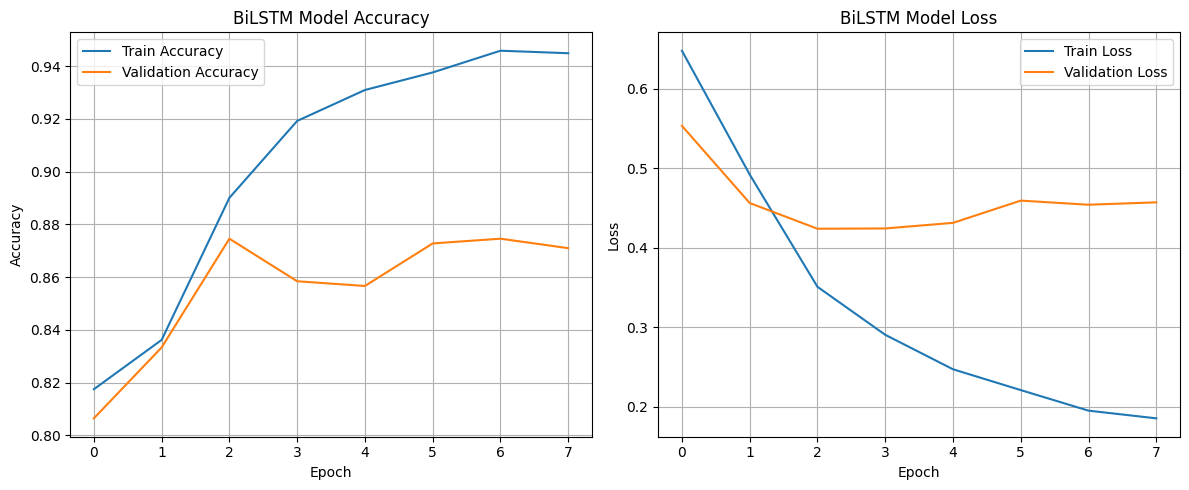

In [67]:
# Plot Akurasi dan Loss untuk LSTM
if history_bilstm:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_bilstm.history['accuracy'], label='Train Accuracy')
    plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
    plt.title('BiLSTM Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history_bilstm.history['loss'], label='Train Loss')
    plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
    plt.title('BiLSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Ringkasan Hasil dan Pemilihan Model Terbaik**

In [68]:
print("\n\n" + "="*20 + " RINGKASAN HASIL EKSPERIMEN " + "="*20)
df_results = pd.DataFrame(results_summary)
df_results = df_results.sort_values(by='akurasi_test', ascending=False)
print(df_results)



==================== RINGKASAN HASIL EKSPERIMEN ====================
                     skema                       model            fitur  \
3  Skema 3 (Deep Learning)          Bidirectional LSTM  Keras Embedding   
0                  Skema 1  Logistic Regression (Best)           TF-IDF   
1                  Skema 2                  SVM (Best)           TF-IDF   
2         Skema 2 (Alt RF)        Random Forest (Best)           TF-IDF   

                    pembagian_data  akurasi_train  akurasi_test  
3  80/20 (dengan validation_split)       0.917340      0.879440  
0                            80/20       0.916263      0.865447  
1                            75/25       0.954911      0.861326  
2                            75/25       0.962665      0.848407  


In [69]:
print("\n\n" + "="*20 + " MODEL TERBAIK YANG DISIMPAN (Akurasi Test >= 85%) " + "="*20)
if best_models_and_vectorizers:
    for model_id, details in best_models_and_vectorizers.items():
        print(f"ID Model: {model_id}, Akurasi Test: {details['accuracy_test']:.4f}, Tipe Fitur: {details['feature_type']}")
else:
    print("Tidak ada model yang mencapai akurasi test minimal 85%.")



==================== MODEL TERBAIK YANG DISIMPAN (Akurasi Test >= 85%) ====================
ID Model: Skema 1_Logistic Regression (Best), Akurasi Test: 0.8654, Tipe Fitur: TF-IDF
ID Model: Skema 2_SVM (Best), Akurasi Test: 0.8613, Tipe Fitur: TF-IDF
ID Model: Skema 3 (Deep Learning)_BiLSTM, Akurasi Test: 0.8794, Tipe Fitur: Keras Embedding


In [70]:
# Pilih model terbaik secara keseluruhan untuk inference
best_overall_model_id = None
highest_overall_acc = 0.0
if best_models_and_vectorizers:
    # Prioritaskan model Deep Learning jika akurasinya >= 92%, atau model dengan akurasi tertinggi jika tidak
    dl_models_above_92 = {k: v for k, v in best_models_and_vectorizers.items() if v['model_type'] == 'deep_learning' and v['accuracy_test'] >= 0.92}
    if dl_models_above_92:
        best_overall_model_id = max(dl_models_above_92, key=lambda k: dl_models_above_92[k]['accuracy_test'])
        highest_overall_acc = dl_models_above_92[best_overall_model_id]['accuracy_test']
    else: # Jika tidak ada DL >= 92%, ambil yang tertinggi dari semua yang >= 85%
        best_overall_model_id = max(best_models_and_vectorizers, key=lambda k: best_models_and_vectorizers[k]['accuracy_test'])
        highest_overall_acc = best_models_and_vectorizers[best_overall_model_id]['accuracy_test']

    print(f"\nModel terbaik untuk inference: {best_overall_model_id} dengan akurasi test: {highest_overall_acc:.4f}")
else:
    print("\nTidak ada model yang memenuhi syarat untuk inference.")


Model terbaik untuk inference: Skema 3 (Deep Learning)_BiLSTM dengan akurasi test: 0.8794
